In [13]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from random import choices
rng = np.random
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
from sklearn.preprocessing import label_binarize
import itertools
from scipy import interp
print(tf.__version__)
import time

1.10.0


In [14]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [15]:
# Read in data from small csv to a dataframe
df1=pd.read_csv('weather_small.csv', sep=',')

# Reformat data in date/time column 
df1['Formatted Date'] =  pd.to_datetime(df1['Formatted Date'])

# Create a new column for year / month / hour
df1['Year'] = pd.DatetimeIndex(df1['Formatted Date']).year
df1['Month'] = pd.DatetimeIndex(df1['Formatted Date']).month
df1['Hour'] = pd.DatetimeIndex(df1['Formatted Date']).hour

# Encode month and hour for cyclical nature
df1 = encode(df1, 'Month', 13)
df1 = encode(df1, 'Hour', 23)
df1 = encode(df1, 'Wind Bearing (degrees)', 359)

# Remove original date/time column
df1=df1.drop(['Formatted Date'],axis=1)

# Convert columns to factors
df1['Summary'] = df1['Summary'].astype('category')
df1['Precip Type'] = df1['Precip Type'].astype('category')
df1['Daily Summary'] = df1['Daily Summary'].astype('category')

# Create a column stating whether its mostly cloudy / overcast or not in summary
df1['Heavy_Cloud'] = pd.np.where(df1.Summary.str.contains("Mostly Cloudy"), 1,
                    pd.np.where(df1.Summary.str.contains("Overcast"), 1,
                    pd.np.where(df1.Summary.str.contains("Foggy"), 1,0)))

# Convert to boolean and print count
df1['Heavy_Cloud']=df1['Heavy_Cloud'].astype('bool')

In [16]:
df1 = df1.rename(index=str, columns={"Apparent Temperature (C)": "Apparent Temperature", "Temperature (C)": "Temperature"})
Y = df1["Apparent Temperature"].values
X = df1["Temperature"].values

In [17]:
y_train = df1.sample(frac = 0.7)
y_test = df1.drop(y_train.index).sample(frac = 0.33)
y_valid=df1.drop(y_train.index).drop(y_test.index)

train_idx=np.array(y_train.index).astype(int)
valid_idx=np.array(y_valid.index).astype(int)
test_idx=np.array(y_test.index).astype(int)

x_train=X[train_idx]
x_valid=X[valid_idx]
x_test=X[test_idx]

print('train: {} | validation: {} | test {}'.format(round(len(y_train)/len(df1),2),
                                                       round(len(y_valid)/len(df1),2),
                                                       round(len(y_test)/len(df1),2)))

train: 0.7 | validation: 0.2 | test 0.1


In [18]:
FEATURES = ["Temperature"]
LABEL = "Apparent Temperature"
feature_cols = [tf.feature_column.numeric_column(k) for k in FEATURES]
estimator = tf.estimator.LinearRegressor(    
        feature_columns=feature_cols,   
        model_dir="train")
def get_input_fn(data_set, num_epochs=None, n_batch = 128, shuffle=True):    
         return tf.estimator.inputs.pandas_input_fn(       
         x=pd.DataFrame({k: data_set[k].values for k in FEATURES}),       
         y = pd.Series(data_set[LABEL].values),       
         batch_size=n_batch,          
         num_epochs=num_epochs,       
         shuffle=shuffle)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'train', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a341d2358>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [19]:
start_time = time.clock()
estimator.train(input_fn=get_input_fn(y_train,                                       
                                           num_epochs=None,                                      
                                           n_batch = 128,                                      
                                           shuffle=False),                                      
                                           steps=1000)
print (time.clock() - start_time, "seconds")

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from train/model.ckpt-24000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 24000 into train/model.ckpt.
INFO:tensorflow:loss = 182.84639, step = 24001
INFO:tensorflow:global_step/sec: 654.496
INFO:tensorflow:loss = 164.06949, step = 24101 (0.153 sec)
INFO:tensorflow:global_step/sec: 947.718
INFO:tensorflow:loss = 215.89117, step = 24201 (0.106 sec)
INFO:tensorflow:global_step/sec: 866.662
INFO:tensorflow:loss = 217.10916, step = 24301 (0.115 sec)
INFO:tensorflow:global_step/sec: 911.262
INFO:tensorflow:loss = 259.35654, step = 24401 (0.110 sec)
INFO:tensorflow:global_step/sec: 916.303
INFO:tensorflow:loss = 212.86206, step = 24501 (0.109 sec)
INFO:tensorflow:global_step/sec: 944.476
INFO:tensorflow:loss = 184.0854, step = 24

In [20]:
ev = estimator.evaluate(    
          input_fn=get_input_fn(y_test,                          
          num_epochs=1,                          
          n_batch = 128,                          
          shuffle=False))
print(ev)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-10-27-18:10:34
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from train/model.ckpt-25000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-27-18:10:35
INFO:tensorflow:Saving dict for global step 25000: average_loss = 1.6517656, global_step = 25000, label/mean = 10.989623, loss = 196.05186, prediction/mean = 10.972008
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 25000: train/model.ckpt-25000
{'average_loss': 1.6517656, 'label/mean': 10.989623, 'loss': 196.05186, 'prediction/mean': 10.972008, 'global_step': 25000}


In [21]:
y = estimator.predict(    
         input_fn=get_input_fn(y_valid,                          
         num_epochs=1,                          
         n_batch = 128,                          
         shuffle=False))
predictions = list(p["predictions"] for p in itertools.islice(y, len(y_valid)))
# print("Predictions: {}".format(str(predictions)))
pred = []
for i in predictions:
    pred.append(i[0])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from train/model.ckpt-25000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [22]:
y = estimator.predict(    
         input_fn=get_input_fn(y_test,                          
         num_epochs=1,                          
         n_batch = 128,                          
         shuffle=False))
predictions = list(p["predictions"] for p in itertools.islice(y, len(y_test)))
# print("Predictions: {}".format(str(predictions)))
pred_test = []
for i in predictions:
    pred_test.append(i[0])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from train/model.ckpt-25000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [23]:
predictions = np.array(pred)
y_valid = y_valid["Apparent Temperature"]
y_valid = np.array(y_valid).astype(float)

SSE=np.sum(np.power(y_valid-predictions,2))
y_mean=np.sum(y_valid)/len(y_valid)
SST=np.sum(np.power(y_valid-y_mean,2))
coef1=1-(SSE/SST)

print ('Coefficient of determination of the prediction on validation data:',coef1)
print('Mean Absolute Error on validation data:',sum(abs(y_valid-predictions))/len(y_valid))
print('Mean Squared Error on validation data:', sum(np.power(y_valid-predictions,2))/len(y_valid))
print('Root Mean Squared Error on validation data:', np.sqrt(sum(np.power(y_valid-predictions,2))/len(y_valid))) 

predictions_test = np.array(pred_test)
y_test = y_test["Apparent Temperature"]
y_test = np.array(y_test).astype(float)

SSE=np.sum(np.power(y_test-predictions_test,2))
y_mean=np.sum(y_test)/len(y_test)
SST=np.sum(np.power(y_test-y_mean,2))
coef2=1-(SSE/SST)

print ('Coefficient of determination of the prediction on test data:',coef2)
print('Mean Absolute Error on test data:',sum(abs(y_test-predictions_test))/len(y_test))
print('Mean Squared Error on test data:', sum(np.power(y_test-predictions_test,2))/len(y_test))
print('Root Mean Squared Error on test data:', np.sqrt(sum(np.power(y_test-predictions_test,2))/len(y_test))) 

Coefficient of determination of the prediction on validation data: 0.9853016241529935
Mean Absolute Error on validation data: 0.9778392000098207
Mean Squared Error on validation data: 1.6713549372668928
Root Mean Squared Error on validation data: 1.2928089330086223
Coefficient of determination of the prediction on test data: 0.9855534644432239
Mean Absolute Error on test data: 0.9839058737917238
Mean Squared Error on test data: 1.6517656091115716
Root Mean Squared Error on test data: 1.2852103365253376


3132
float64
3132
float64
3132
float32
Hello


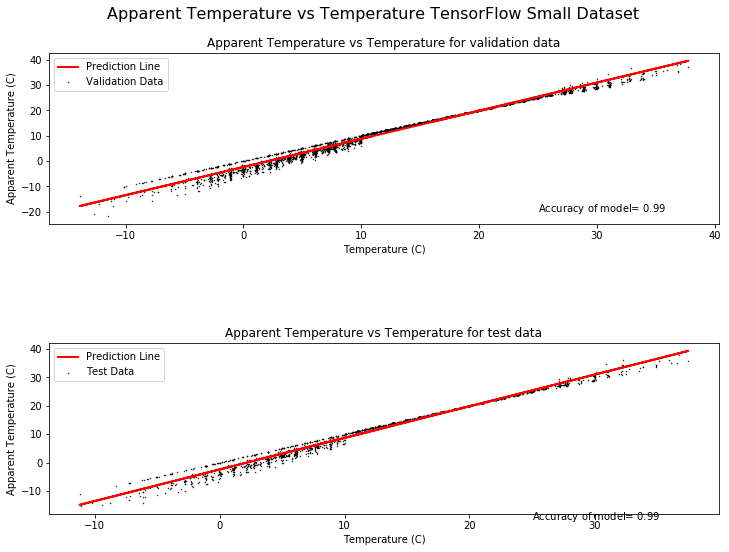

In [24]:


print(len(x_valid))
print(x_valid.dtype)
print(len(y_valid))
print(y_valid.dtype)
print(len(predictions))
print(predictions.dtype)

fig, (ax1,ax2) =plt.subplots(nrows=2,ncols=1,figsize=(12,8))
# Plot outputs of the actual validation data vs the prediction line
fig.suptitle('Apparent Temperature vs Temperature TensorFlow Small Dataset', fontsize=16)

ax1.scatter(x_valid, y_valid, color='black', s=0.2,label='Validation Data')
ax1.plot(x_valid, predictions, color = 'r', linewidth=2,label='Prediction Line')
ax1.set_xlabel('Temperature (C)')
ax1.set_ylabel('Apparent Temperature (C)')
ax1.set_title('Apparent Temperature vs Temperature for validation data')
ax1.legend(loc=2)
textstr = 'Accuracy of model= $%.2f$'%(coef1)
ax1.text(25,-20,textstr)

# Plot outputs of the test data vs the prediction line

ax2.scatter(x_test, y_test, color='black', s=0.2,label='Test Data')
ax2.plot(x_test, predictions_test, color = 'r', linewidth=2,label='Prediction Line')
ax2.set_xlabel('Temperature (C)')
ax2.set_ylabel('Apparent Temperature (C)')
ax2.set_title('Apparent Temperature vs Temperature for test data')
ax2.legend(loc=2)
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.125, right=0.9, hspace=0.7,wspace=0.5)
textstr = 'Accuracy of model= $%.2f$'%(coef2)
ax2.text(25,-20,textstr)

fig.savefig('Linear_Regression_Small_TF.png',pdi=600)
print('Hello')